# HarvestStat Data Profiling - Central African Republic

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32633' # Central African Republic
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/CF_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
#auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Central African Republic',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})#auth=auth, 
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1974	 | CF1974A1 | 17	| nan	| 0	| nan	| 0	|
| 2003	 | CF2003A1 | 17	| CF2003A2	| 72	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# Replace season name
df['season_name'] = df['season_name'].replace({
    'Main harvest': "Main"
})
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Harvested')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([CF_Admin1_2003], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 960
Removed 294 "Missing Value" points
222/240 "Area Harvested" points are retained.
0/240 "Area Planted" points are retained.
222/240 "Quantity Produced" points are retained.
222/240 "Yield" points are retained.
Current data points: 666

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 2014 - 2016
5 grain types are found: Cassava, Groundnuts (In Shell), Maize (Corn), Rice (Paddy), Sesame Seed
1 seasons are found: Main (08-01)
1 crop production system are found: none
Data sources include:
[1] MCDR/DSDI/FAO --- MSAM, Central African Republic
Administrative-1 fnids: 16
Administrative-2 fnids: 0
0 reporting units are found: 

- Total production over time ------------------ #
season_name             Main
                            
Cassava                69.4%
Groundnuts (In Shell)  13.6%
Maize (Corn)           11.0%
Rice (Paddy)            1.5%
Sesame S

- Central African Republic crop seasonal calendar

<img src="../figures/crop_calendar/seasonal-calendar-central-african-republic.png"  width=900><br>

<img src="../figures/crop_calendar/wafrica_ct_calendar.png"  width=900>

- FDW data consists of `CF2003A1`.

| Year  | Admin-1  | # units  | Admin-2  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   |
| 1974  | CF1974A1 | 17       | -        | -       |
| 2003  | **`CF2003A1`** | 17       | CF2003A2 | 72       |

- Comparison between admin boundaries.

<img src="../figures/CF_admin_shapes.png"  width=900>

- **FDW data consists of only 3 years records.**
- **`CF2003A1`** is used to represent the current admin-level 1 crop data.
- Central African Republic has a single crop season: `Main`.
- Central African Republic has no population group(s).

In [4]:
# Define the latest shapefile ------------------- #
shape_latest = CF_Admin1_2003.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area_new, prod_new = FDW_PD_Compiling(df, shape_used)
# ----------------------------------------------- #

In [5]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Cassava': 'Cassava',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
    'Maize (Corn)': 'Maize',
    'Rice (Paddy)': 'Rice',
    'Sesame Seed': 'Sesame Seed',
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Central African Republic']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_CF.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_CF.csv is saved.


# Visualization of production data

../figures/CF_bar_natgrainprod_Main.png is saved.


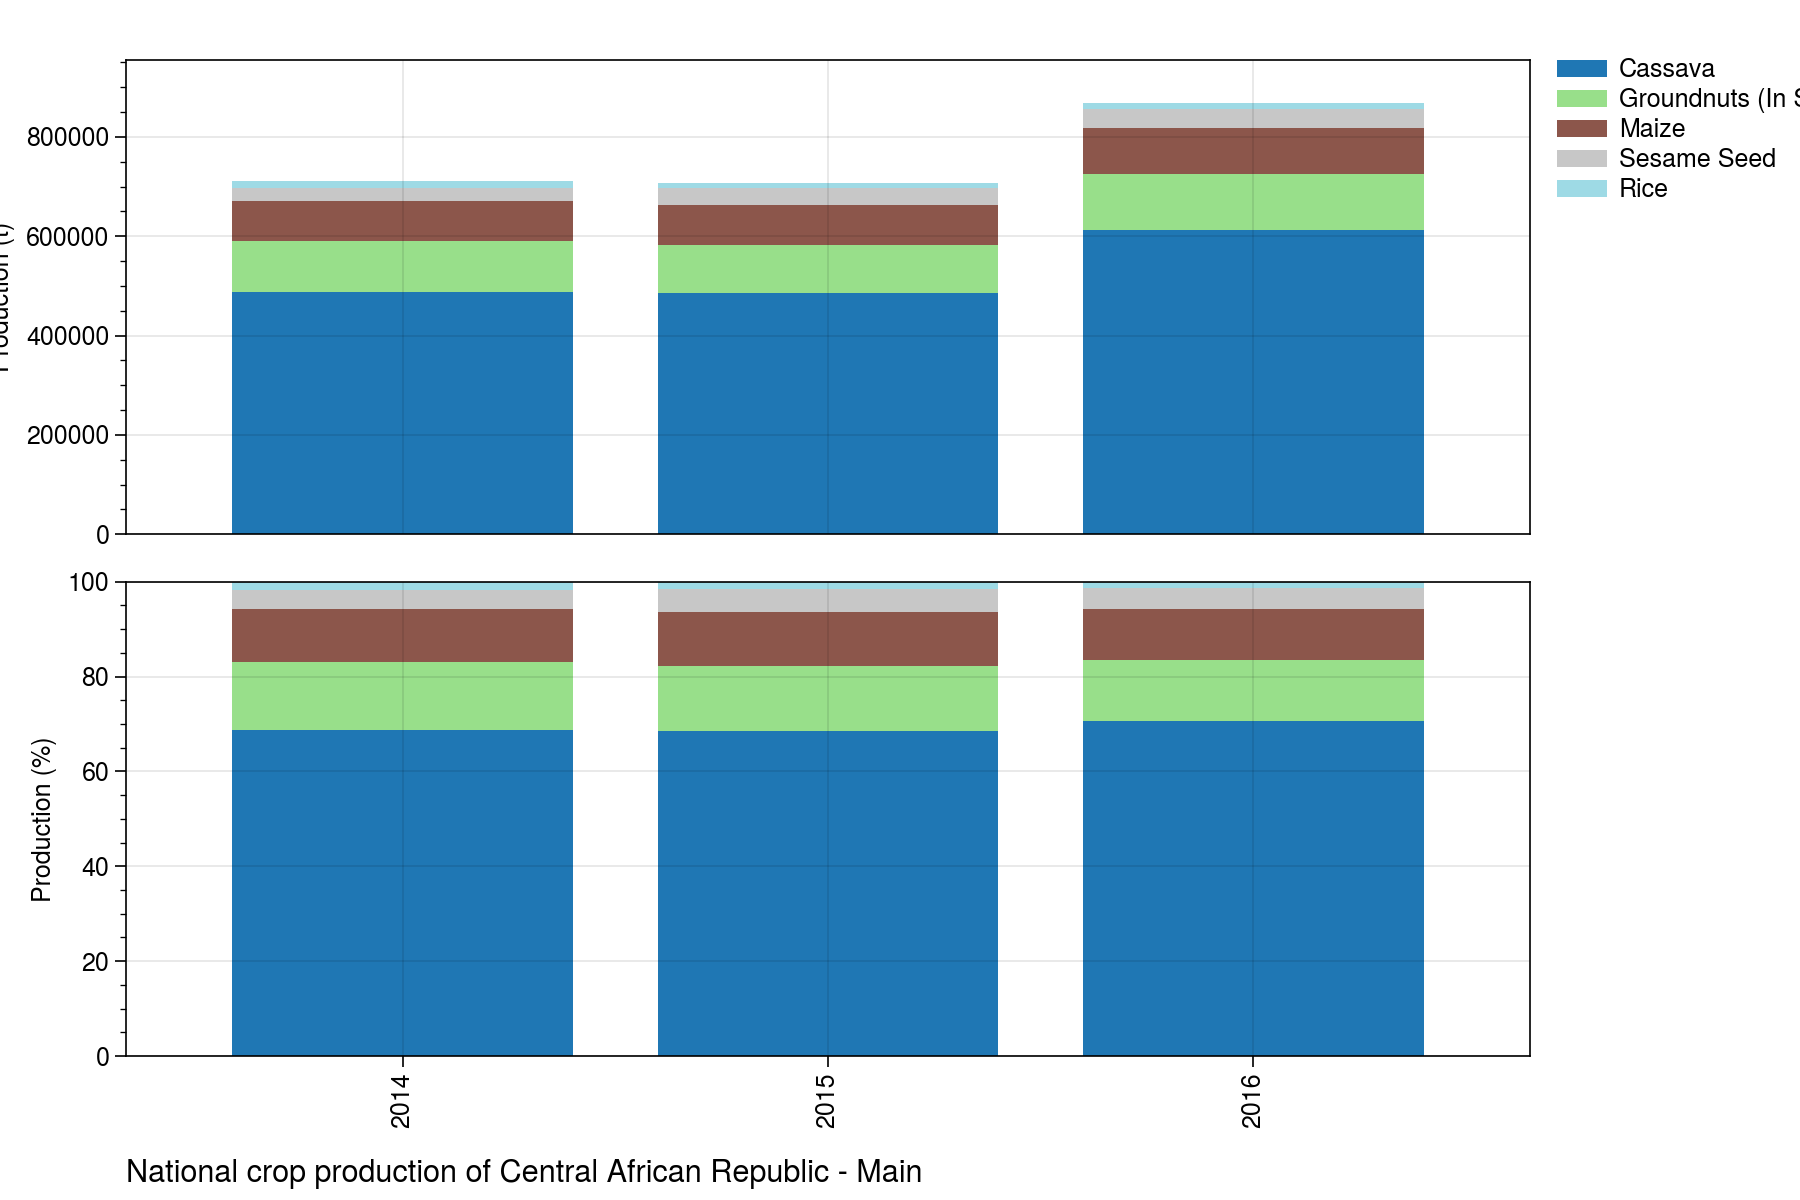

In [6]:
# Bar chart of national crop production
country_iso, country_name = 'CF', 'Central African Republic'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

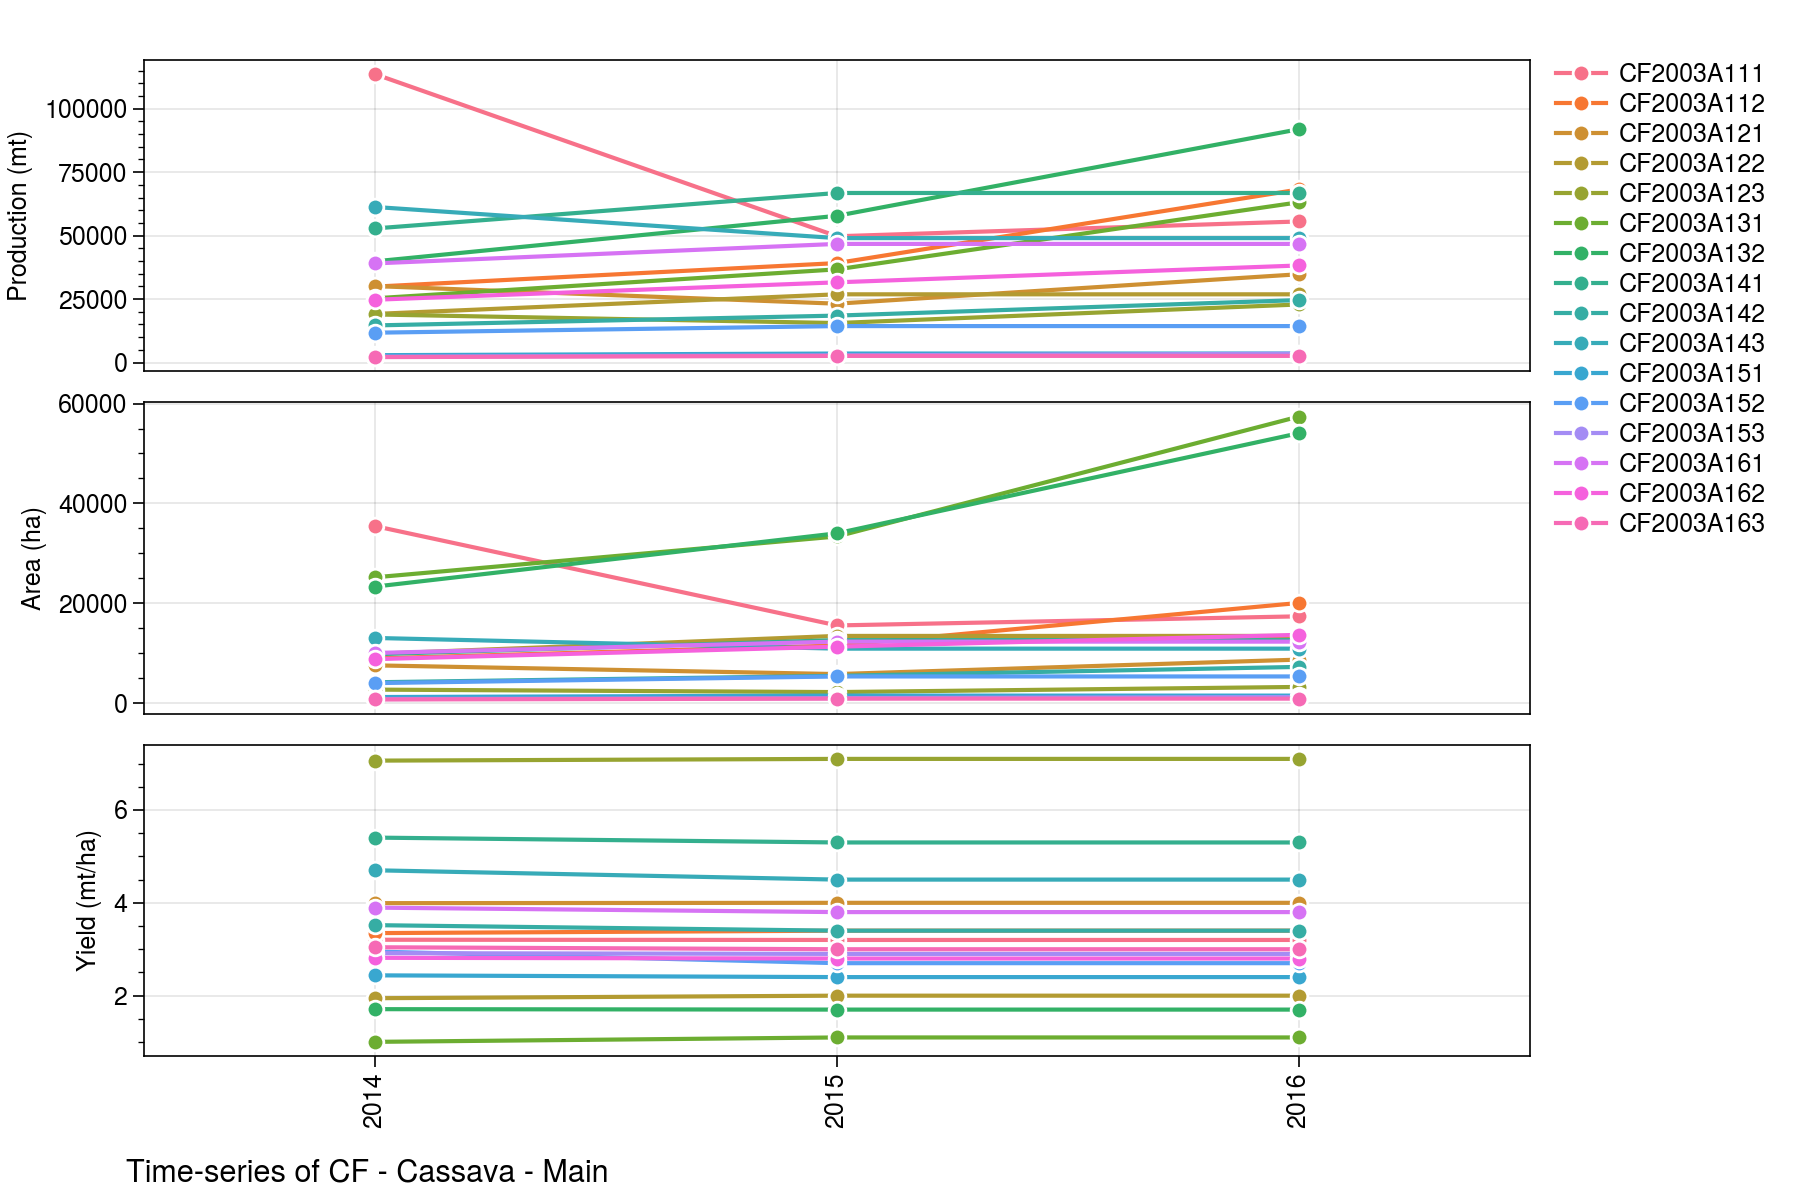

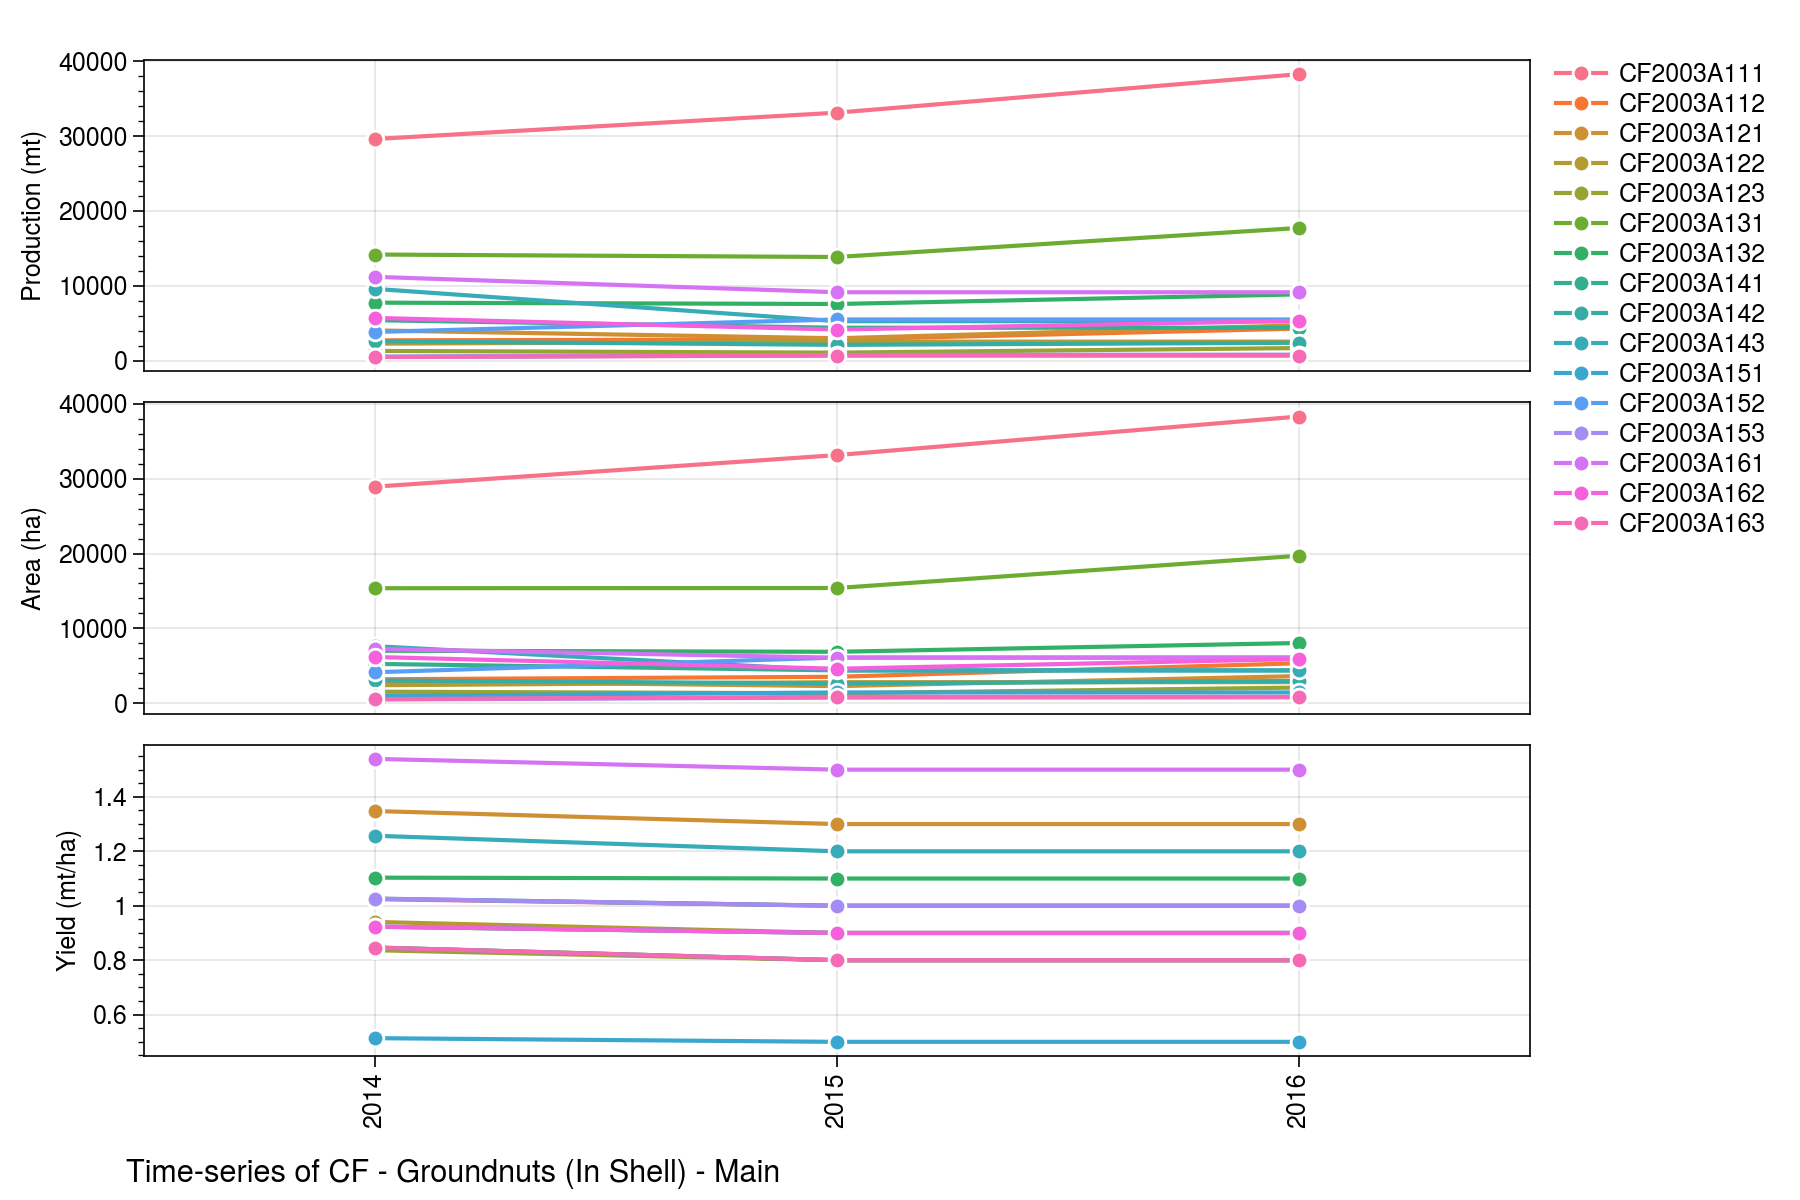

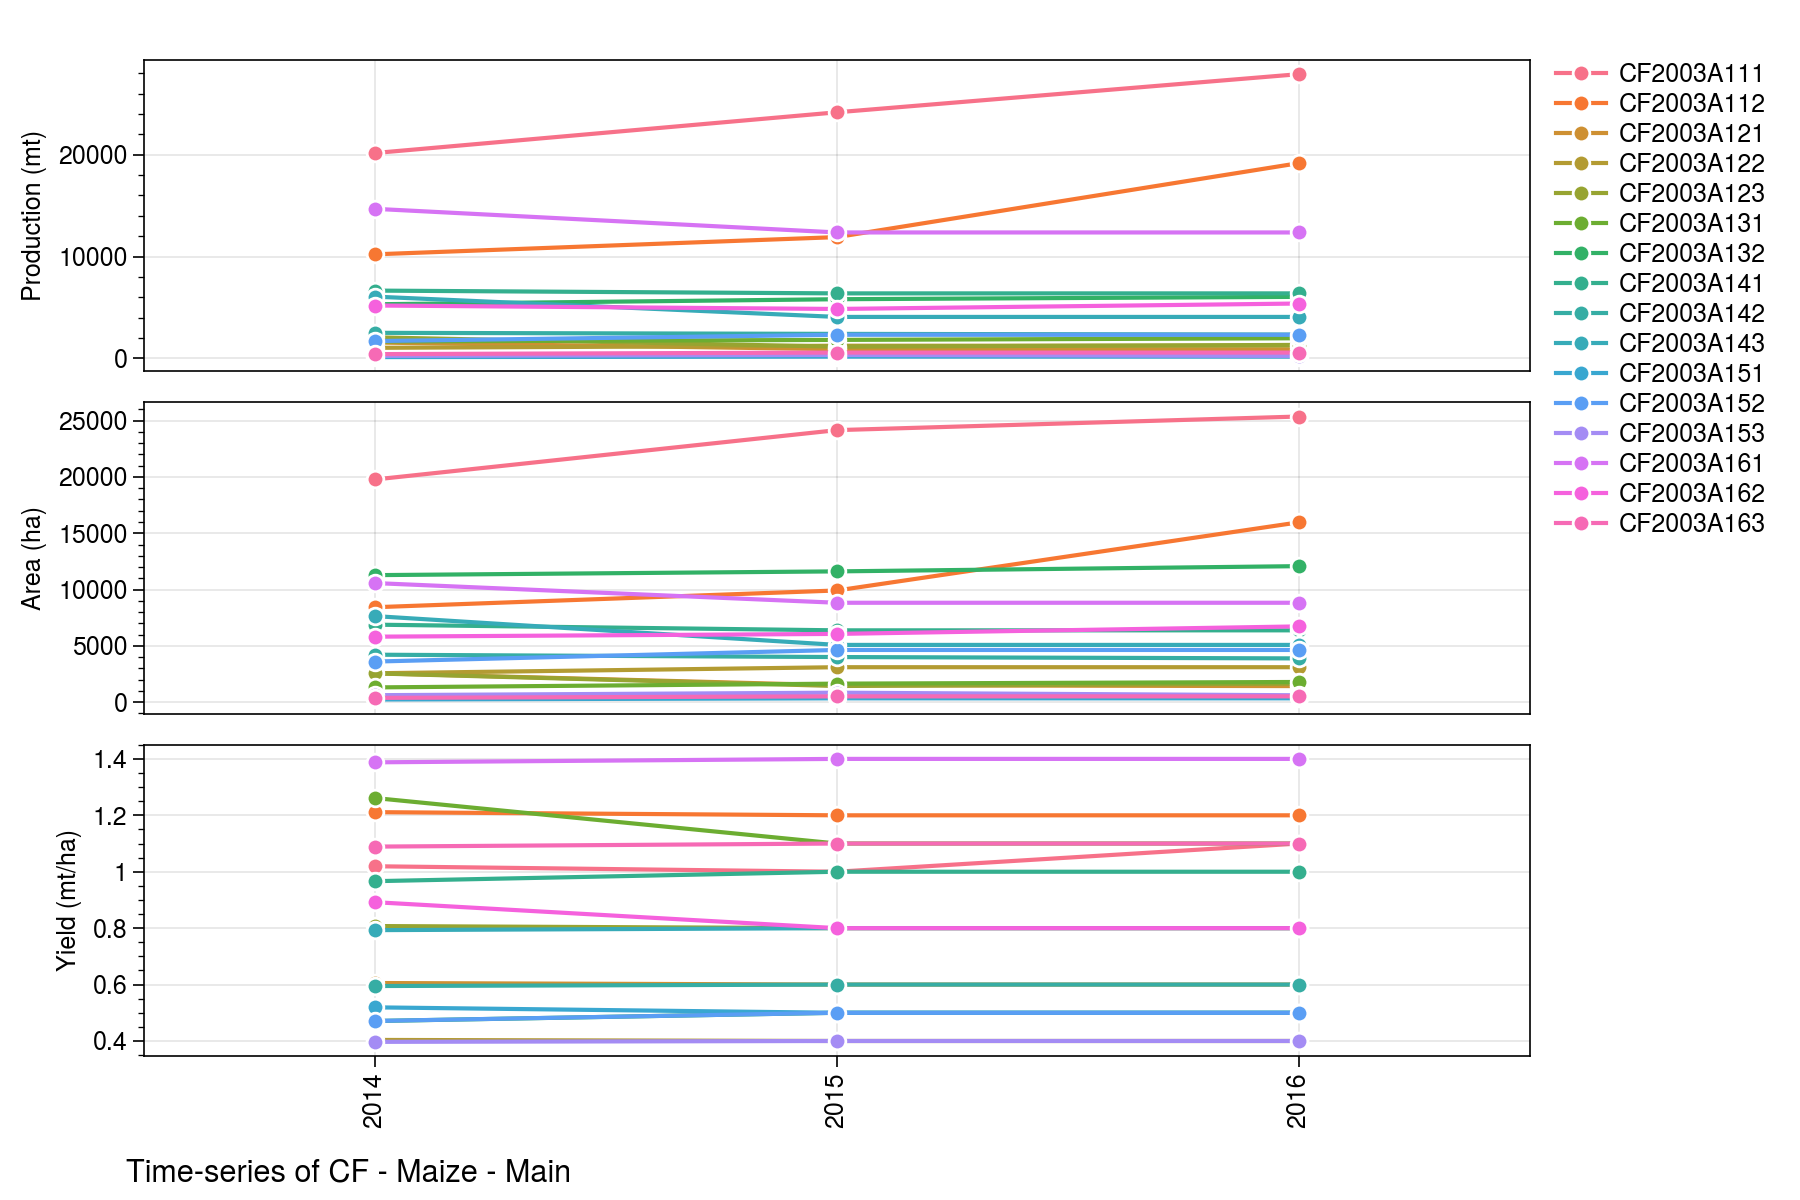

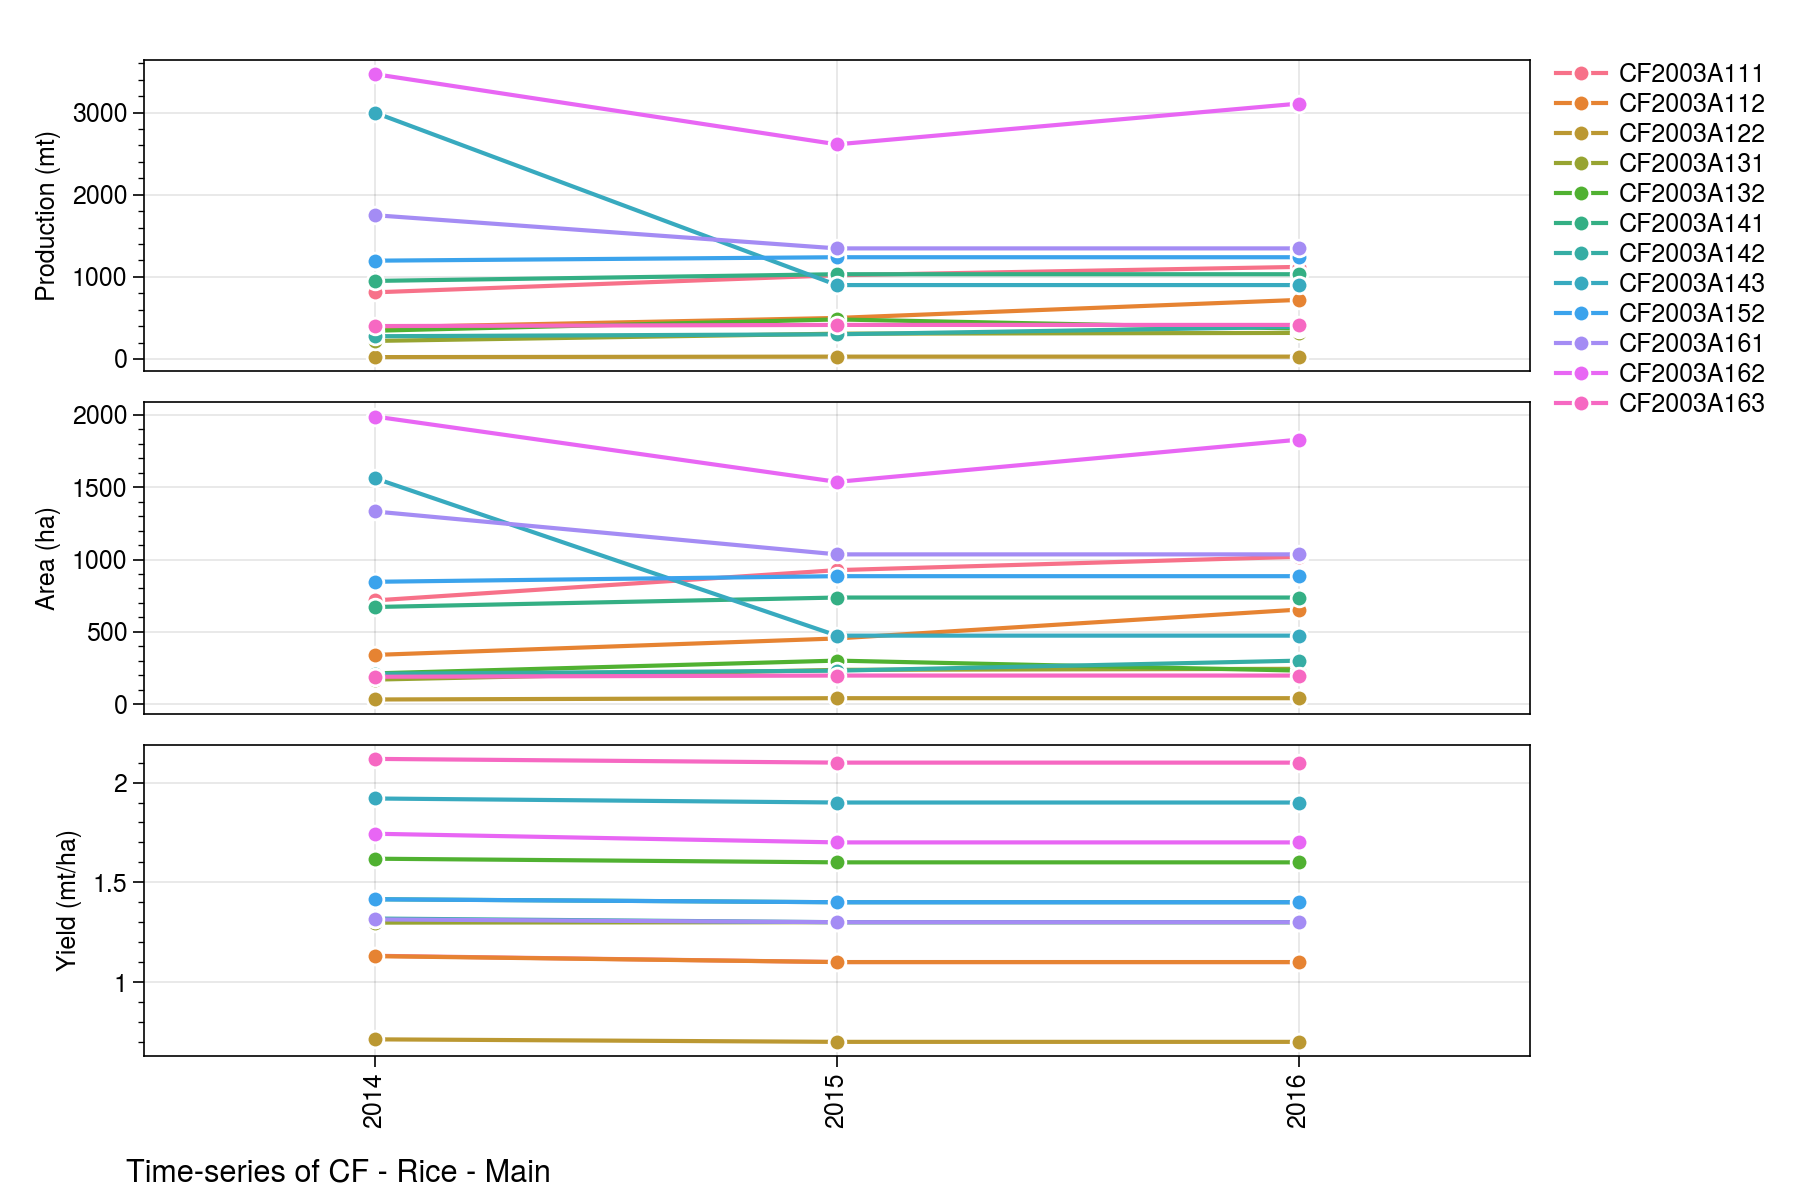

In [7]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'CF', 'Central African Republic'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Cassava','Main'],
    ['Groundnuts (In Shell)','Main'],
    ['Maize','Main'],
    ['Rice','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)